
# Gas Price Forecast


**Business Overview**: You work at Trucks Inc. Your company with a marketplace business model, the company brings together Self-Employed Truck Drivers and Third Party Truck Drivers with other companies that need a truck driver to move all types of materials, such as gasoline, food (processed or not, for example, frozen meat, forzen fruits, cotton, wheat, seasonings, drinks of all types and so on) all these products are requested by companies that need a truck driver.
One side of the marketplace are companies, they all need to create an account with valid credentials and request a driver for specific locations, risk, time range to complete, intervals, priority and the company can price the trip reward or not, to all positions. of travel, Trucks Inc receives a per postage a fee.
On the other side of the marketplace are self-employed truck drivers or third-party drivers, everyone also needs to create a truck driver account and find all the trips available for them to join, after the truck driver choise the traveling, the Truck Inc make a Interview with Driver and Third Company for validate the traveling and completes the process of marketplace.

**Business Problem**: At Trucks Inc, you need to expand the marketing campaign to acquire new self-employed truck drivers, one of the hypotheses raised by the Head of Marketing was to use the price of gasoline as an incentive to attract the attention of truck drivers, as the company has a lot of trips in progress. currently open but there are around 50% of active truck drivers on the platform, so the Head of Marketing has a proposal to pay 50% of the fuel needed for the truck driver's trip if he completes a trip on the platform.
In this scenario, you need to forecast the gas price for all regions and give a statistics overview of all available regions based on gas price for for Head of Marketing decisions.


## 0.0. Requirements


### 0.1. Imports

In [ ]:
import re
import uuid
import mlflow
import logging
import optuna
import hyperopt

import numpy as np
import pandas as pd
import seaborn as sns

from time import sleep
from calendar import month_abbr
from matplotlib import pyplot as plt
from datetime import datetime, timedelta

from databricks import feature_store

from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score

from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from xgboost import XGBRegressor
from mlforecast import MLForecast
from mlforecast.target_transforms import Differences
from statsforecast import StatsForecast
from statsforecast.models import (
    MSTL,
    AutoETS,
    AutoCES,
    AutoTheta,
    AutoARIMA
)

from window_ops.ewm import ewm_mean
from window_ops.expanding import expanding_mean

from window_ops.rolling import (
    rolling_mean,
    seasonal_rolling_mean,
    rolling_min,
    rolling_max,
    rolling_std
)


from sklearn.base import BaseEstimator
from sklearn.tree import plot_tree, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor 

from pyspark.sql import functions as pf

from warnings import filterwarnings

filterwarnings("ignore")

In [ ]:
!pip freeze

absl-py==1.0.0
adagio==0.2.4
alembic==1.13.1
appdirs==1.4.4
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
astor==0.8.1
asttokens==2.0.5
astunparse==1.6.3
attrs==21.4.0
azure-core==1.26.3
azure-cosmos==4.2.0
backcall==0.2.0
backports.entry-points-selectable==1.2.0
bcrypt==3.2.0
beautifulsoup4==4.11.1
black==22.3.0
bleach==4.1.0
blis==0.7.9
boto3==1.21.32
botocore==1.24.32
cachetools==4.2.2
catalogue==2.0.8
category-encoders==2.5.1.post0
certifi==2021.10.8
cffi==1.15.0
chardet==4.0.0
charset-normalizer==2.0.4
click==8.0.4
cloudpickle==2.0.0
cmdstanpy==1.1.0
colorlog==6.8.2
confection==0.0.4
configparser==5.2.0
convertdate==2.4.0
coreforecast==0.0.9
cryptography==3.4.8
cycler==0.11.0
cymem==2.0.7
Cython==0.29.28
databricks-automl-runtime==0.2.15
databricks-cli==0.17.4
databricks-feature-store==0.10.1
dbl-tempo==0.1.12
dbus-python==1.2.16
debugpy==1.5.1
decorator==5.1.1
defusedxml==0.7.1
dill==0.3.4
diskcache==5.4.0
distlib==0.3.6
distro==1.4.0
distro-info==0.23+ubuntu1.1
docstring-to-m


### 0.2. Aux Functions

In [ ]:
def get_ml_metrics(
    df: pd.DataFrame,
    ytrue: str = "price",
    yhat: str = "yhat",
    return_df = False,
    k: int = 1
):
    r2 = r2_score(df[ytrue], df[yhat])
    mse = mean_squared_error(df[ytrue], df[yhat])
    rmse = np.sqrt(mean_squared_error(df[ytrue], df[yhat]))

    df["resid"] = df[ytrue] - df[yhat]
    df = df.sort_values("resid")

    resid_sum = df["resid"].sum()

    try:
        _, pval_s = stats.shapiro(df["resid"])
        _, pval_n = stats.normaltest(df["resid"])

    except:
        pval_s = 0
        pval_n = 0

    metrics = {"r2": r2, "mse": mse, "rmse": rmse,
        "sred": resid_sum, "pv_shap": pval_s, "pv_norm": pval_n, "k": k
    }

    if return_df:
        return metrics, df
    
    else:
        return metrics

def plot_resid_analysis(
    df_test: pd.DataFrame,
    x: str = "date",
    ytrue: str = "price",
    yhat: str = "yhat",
    region: str = None,
    region_col: str = "unique_id",
):
    if region:
        test = df_test[df_test[region_col] == region]

    else:
        test = df_test[[x, ytrue, yhat]].groupby(x).sum().reset_index()

    metrics, test = get_ml_metrics(test, return_df=True, yhat=yhat, ytrue=ytrue)

    fig, _, = plt.subplots(figsize=(15,10))
    ax0 = plt.subplot2grid((3, 3), (0, 0), colspan=3)
    ax1 = plt.subplot2grid((3, 3), (1, 0))
    ax2 = plt.subplot2grid((3, 3), (1, 1))
    ax3 = plt.subplot2grid((3, 3), (1, 2))
    ax4 = plt.subplot2grid((3, 3), (2, 0), colspan=3);

    test.plot(x=x, y="resid", marker="o", color="k", ax=ax0)
    sns.scatterplot(x=test[ytrue], y=test[yhat], ax=ax1)

    ax2.hist(test["resid"], bins=20)
    stats.probplot(test["resid"], plot=ax3)
    plot_acf(test["resid"], lags=range(1, len(test)), ax=ax4);
    ax3.annotate(f"SW P: {metrics['pv_shap']:.4f}\nNT P: {metrics['pv_norm']:.4f}\n$\\sum e$: {metrics['sred']:.4f}", xy=(0.05, 0.7), xycoords='axes fraction', fontsize=10)

    for axi in [ax0, ax1, ax2, ax3, ax4]:
        axi.grid(2)

    plt.tight_layout()

    return fig, metrics

def plot_future_multiple_forecasting(
    df_history: pd.DataFrame,
    df_forecasting: pd.DataFrame,
    plot_unique_ids: list = ["us", "san_francisco", "ohio"],
    forecasting_col: str = "MSTL",
    target_col: str = "y",
    date_col: str = "ds",
    unique_id_col: str = "unique_id"
):
    fig, ax = plt.subplots(figsize=(13, 6))
    for unique_id in df_forecasting[unique_id_col].unique():
        dfp = df_forecasting[df_forecasting[unique_id_col] == unique_id]
        
        if unique_id in plot_unique_ids:
            df_history[(df_history[unique_id_col] == unique_id) & (df_history[date_col] >= "2024-01-01")].plot(x=date_col, y=target_col, color="k", linestyle="--", ax=ax, label=unique_id)
            dfp.plot(x=date_col, y=forecasting_col, label=unique_id, ax=ax, linestyle="--")

        else:
            dfp.plot(x=date_col, y=forecasting_col, label=unique_id, ax=ax)

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_title("Forecasting")
    ax.grid(2)

    return fig

def plot_train_test_forecast(
    df_train: pd.DataFrame,
    df_test: pd.DataFrame,
    date_col: str,
    ytrue: str,
    yhat: str
):
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.grid(2)
    ax.set_title("Train, Test and Forecast")

    df_train.plot(x=date_col, y=ytrue, ax=ax, color="k", label="train")
    df_test.plot(x=date_col, y=ytrue, ax=ax, color="r", label="true")
    df_test.plot(x=date_col, y=yhat, ax=ax, label="yhat", color="b", linestyle="--", grid=2);

    return fig

def mlflow_log_cv_experiment(
    cv_results: dict,
    experiment_id
):
    log_mean_metrics, log_std_metrics, desc_metrics, k_fold_metrics = describe_ml_metrics(cv_results)
    log_mean_metrics, log_std_metrics = pd.DataFrame(log_mean_metrics), pd.DataFrame(log_std_metrics)

    for estimator_name in {estimator["estimator"] for estimator in cv_results}:
        print(f"Logging Model: {estimator_name}")

        with mlflow.start_run(
            nested=True,
            experiment_id=experiment_id,
            run_name=f"{str(estimator_name)}-{str(uuid.uuid1())[:7]}"
        ) as run:
            estimator_log_std_metrics = log_std_metrics[log_std_metrics["estimator"] == estimator_name].drop(columns="estimator", axis=1).to_dict(orient="records")[0]
            estimator_log_mean_metrics = log_mean_metrics[log_mean_metrics["estimator"] == estimator_name].drop(columns="estimator", axis=1).to_dict(orient="records")[0]

            mlflow.log_metrics(estimator_log_std_metrics)
            mlflow.log_metrics(estimator_log_mean_metrics)

    return desc_metrics

In [ ]:
def prequential_sliding_blocks(
    df: pd.DataFrame,
    gap_months: int = 1,
    validation_months: int = 4,
    cutoff_date: datetime = datetime(2021, 1, 1),
    plot_interval: bool = False,
    date_col: str = "date",
    target_col: str = "price"
):

    train_idx_list = []
    valid_idx_list = []

    while df[date_col].max() >= cutoff_date:
        # Training and Valid with one month gap pandas spliting
        start_cutoff_date_gap = (cutoff_date + pd.DateOffset(months=gap_months)).strftime("%Y-%m") + "-01"
        end_cutoff_end_date_gap = (cutoff_date + pd.DateOffset(months=gap_months + validation_months)).strftime("%Y-%m") + "-01"

        df_train = df[df[date_col] < cutoff_date.strftime("%Y-%m-%d")]
        df_valid = df[(df[date_col] > start_cutoff_date_gap) & (df[date_col] < end_cutoff_end_date_gap)]

        # if do not have data, than break
        if df_valid.empty: break

        if plot_interval:
            ax = df_train.plot(x=date_col, y=target_col, label="train", figsize=(8, 4))
            df_valid.plot(x=date_col, y=target_col, color="r", ax=ax, label="valid", grid=2)
            ax.set_title(f"Valid: {df_valid[date_col].min().strftime('%Y-%m-%d')} -> {df_valid[date_col].max().strftime('%Y-%m-%d')}");

        cutoff_date += pd.DateOffset(months=validation_months)

        train_idx_list.append(df_train.index.values)
        valid_idx_list.append(df_valid.index.values)

    return train_idx_list, valid_idx_list

def describe_ml_metrics(
    metrics_list: list[dict]
) -> tuple:
    k_fold_metrics = pd.DataFrame(metrics_list)
    k_fold_metrics.sort_values(by="k", inplace=True, ascending=True)

    if "estimator" not in k_fold_metrics.columns: k_fold_metrics["estimator"] = "base"
    desc_metrics = k_fold_metrics.groupby("estimator").apply(lambda x: x.describe()).T
    
    log_mean_metrics, log_std_metrics = [], []
    for estimator_name in {j[0] for j in desc_metrics.columns}:
        log_mean_metrics.append({"m_" + k: v for k, v in desc_metrics[estimator_name]["mean"].to_dict().items()} | {"estimator": estimator_name})
        log_std_metrics.append({"s_" + k: v for k, v in desc_metrics[estimator_name]["std"].to_dict().items()} | {"estimator": estimator_name})

    return log_mean_metrics, log_std_metrics, desc_metrics, k_fold_metrics


def cv_mean_baseline(
    df: pd.DataFrame,
    model: BaseEstimator,
    verbose: bool = False,
    plot_interval: bool = False,
    date_col: str = "date",
    target_col: str = "price",
    unique_id_col: str = "unique_id",
    estimator_name: str = "base",
    base_sklearn = None
):
    train_idx_list, valid_idx_list = prequential_sliding_blocks(
        df=df,
        date_col=date_col,
        target_col=target_col,
        plot_interval=plot_interval
    )

    cv_metrics = []
    for k, index in enumerate(zip(train_idx_list, valid_idx_list)):
        k += 1
        ti, vi = index
        df_train = df[df.index.isin(ti)].reset_index(drop=True)
        df_valid = df[df.index.isin(vi)].reset_index(drop=True)

        y_train = df_train[target_col]
        y_valid = df_valid[target_col]

        if base_sklearn:
            df_train.drop(columns=[date_col, target_col], inplace=True)
            model.fit(df_train, y_train)

        else:
            model.fit(df_train)

        if type(model) == StatsForecast or type(model) == MLForecast:
            forecastings = model.predict(h=df_valid[date_col].nunique()).reset_index()
            if "index" in forecastings.columns:
                forecastings.drop(columns="index", axis=1, inplace=True)

            estimator_list = forecastings.drop(columns=[date_col, unique_id_col], axis=1).columns.values

            for estimator_name in estimator_list:
                model_forecastings = forecastings[[date_col, unique_id_col, estimator_name]].rename(columns={estimator_name: "yhat"})
                model_forecastings = pd.merge(df_valid, model_forecastings, on=[date_col, unique_id_col])

                metrics = get_ml_metrics(model_forecastings, ytrue=target_col, k=k)
                metrics = metrics | {"estimator": estimator_name}
                cv_metrics.append(metrics)

        else:
            model_forecastings = model.predict(df_valid[df_train.columns])

            if type(model_forecastings) == np.ndarray:
                model_forecastings = pd.DataFrame({"yhat": model_forecastings, target_col: df_valid[target_col].values, "date_col": df_valid[date_col].values})

            metrics = get_ml_metrics(model_forecastings, ytrue=target_col, k=k)
            metrics = metrics | {"estimator": estimator_name}
            cv_metrics.append(metrics)
    
    return cv_metrics


In [ ]:
class MeanEstimator(BaseEstimator):
    def __init__(
        self, 
        *,
        estimator_name: str = "MeanEstimator",
        target_col: str = "price",
        unique_id_col: str = "region",
        date_col: str = "date"
    ):
        self.estimator_name = estimator_name
        self.target_col = target_col
        self.unique_id_col = unique_id_col
        self.date_col = date_col
        self.X = None
    
    def fit(self, X, y=None):
        self.X = X
        return self
    
    def predict(self, X):
        means = self.X[[self.unique_id_col, self.target_col]].groupby(self.unique_id_col).mean().reset_index().rename(columns={self.target_col: "yhat"})
        return pd.merge(X[[self.date_col, self.unique_id_col, self.target_col]].reset_index(drop=2), means, on=["region"])


### 0.3. Load Data

In [ ]:
fs = feature_store.FeatureStoreClient()
df_raw = fs.read_table("gas_price_raw_features")


## 1.0. Data Preparation


In this step I will prepare the dataset, it is possible to apply all types of pre-processing to the dataset. For machine learning in general, estimators trained with features of different sizes (ranges) may apply more weight to out-of-the-box features such as neural network (multiply a very large w for a given feature x), but other estimators such as tree-based which is just the horizontal slice of the feature space, does not need rescaling, but if I choose other estimators, it is necessary to apply transformation and rescaling to all other features.

For univarite time series purpouses, the transformation has two main purpouses: fist remove heteroskedasticity and transform a multiplicative series into a additive series, in the same perspective, Granger & Newbold (1976) show that the transformed series can apply bias to classical forecasting estimators such as Arima.

A good tool for inspecting the need for a transformation is a chart for checking k-sample range subsamples of the time series, it is a heteroskedasticity check scatterplot.

I can use SKlearn pipeline or other king of hand tool for feature engineering and automatic feature transformation, but i will create mannually for studying purpouses.


In [ ]:
df = df_raw[df_raw["date"] >= "2020-01-01"].reset_index(drop=True)

In [ ]:
df.head()

,region,date,price,future,lag_4_months,lag_5_months,lag_12_months_plus,lag_12_months,lag_12_months_minus,diff_4_months,diff_5_months,diff_12_months_plus,diff_12_months,diff_12_months_minus,latitude,longitude,day,year,month,quarter,week
0,boston_ma,2020-01-05,2.643,False,2.739,2.806,2.651,2.603,2.539,-0.741,0.139,0.160,0.476,0.146,42.367970,-71.052616,5,2020,1,1,1
1,california,2020-01-05,3.517,False,3.569,3.625,3.332,3.296,3.261,1.151,0.880,1.127,0.823,0.909,36.701463,-118.755997,5,2020,1,1,1
2,central_atlantic,2020-01-05,2.694,False,2.697,2.853,2.530,2.491,2.467,-0.026,0.167,-0.023,0.065,0.094,47.590493,-122.324313,5,2020,1,1,1
3,chicago,2020-01-05,2.731,False,2.879,3.193,2.346,2.239,2.237,0.410,0.661,-0.143,-0.189,-0.032,41.875562,-87.624421,5,2020,1,1,1
4,cleveland_oh,2020-01-05,2.692,False,2.622,2.762,2.102,2.014,2.011,0.070,0.192,-0.357,-0.318,-0.040,41.539417,-81.635238,5,2020,1,1,1



### 1.1. Nature Transformation

In [ ]:
df["day_sin"] = df["day"].apply(lambda x: np.sin(x * (2. * np.pi / 30)))
df["day_cos"] = df["day"].apply(lambda x: np.cos(x * (2. * np.pi / 30)))
df["week_sin"] = df["week"].apply(lambda x: np.sin(x * (2. * np.pi / 52)))
df["week_cos"] = df["week"].apply(lambda x: np.cos(x * (2. * np.pi / 52)))
df["month_sin"] = df["month"].apply(lambda x: np.sin(x * (2. * np.pi / 12)))
df["month_cos"] = df["month"].apply(lambda x: np.cos(x * (2. * np.pi / 12)))
df["quarter_sin"] = df["quarter"].apply(lambda x: np.sin(x * (2. * np.pi / 4)))
df["quarter_cos"] = df["quarter"].apply(lambda x: np.cos(x * (2. * np.pi / 4)))


### 1.2. Encoding

In [ ]:
region_mapping = {
    'boston_ma': 0,
    'california': 1,
    'central_atlantic': 2,
    'chicago': 3,
    'cleveland_oh': 4,
    'colorado': 5,
    'denver': 6,
    'east_coast': 7,
    'florida': 8,
    'gulf_coast': 9,
    'houston': 10,
    'los_angeles': 11,
    'lower_atlantic': 12,
    'massachusetts': 13,
    'miami_fl': 14,
    'midwest': 15,
    'minnesota': 16,
    'new_england': 17,
    'new_york': 18,
    'new_york_city': 19,
    'ohio': 20,
    'rocky_mountain': 21,
    'san_francisco': 22,
    'seattle_wa': 23,
    'texas': 24,
    'us': 25,
    'washington': 26,
    'west_coast': 27
}

df.region = df.region.map(region_mapping)

In [ ]:
df.head()

,region,date,price,future,lag_4_months,lag_5_months,lag_12_months_plus,lag_12_months,lag_12_months_minus,diff_4_months,diff_5_months,diff_12_months_plus,diff_12_months,diff_12_months_minus,latitude,longitude,day,year,month,quarter,week,day_sin,day_cos,week_sin,week_cos,month_sin,month_cos,quarter_sin,quarter_cos
0,0,2020-01-05,2.643,False,2.739,2.806,2.651,2.603,2.539,-0.741,0.139,0.160,0.476,0.146,42.367970,-71.052616,5,2020,1,1,1,0.866025,0.5,0.120537,0.992709,0.5,0.866025,1.0,6.123234e-17
1,1,2020-01-05,3.517,False,3.569,3.625,3.332,3.296,3.261,1.151,0.880,1.127,0.823,0.909,36.701463,-118.755997,5,2020,1,1,1,0.866025,0.5,0.120537,0.992709,0.5,0.866025,1.0,6.123234e-17
2,2,2020-01-05,2.694,False,2.697,2.853,2.530,2.491,2.467,-0.026,0.167,-0.023,0.065,0.094,47.590493,-122.324313,5,2020,1,1,1,0.866025,0.5,0.120537,0.992709,0.5,0.866025,1.0,6.123234e-17
3,3,2020-01-05,2.731,False,2.879,3.193,2.346,2.239,2.237,0.410,0.661,-0.143,-0.189,-0.032,41.875562,-87.624421,5,2020,1,1,1,0.866025,0.5,0.120537,0.992709,0.5,0.866025,1.0,6.123234e-17
4,4,2020-01-05,2.692,False,2.622,2.762,2.102,2.014,2.011,0.070,0.192,-0.357,-0.318,-0.040,41.539417,-81.635238,5,2020,1,1,1,0.866025,0.5,0.120537,0.992709,0.5,0.866025,1.0,6.123234e-17



## 2.0. Feature Selection


## 3.0. Machine Learning

In [ ]:
df3 = df.copy()
f = (df3["future"] == True)

In [ ]:
train = df3[~f].copy()

date_train_test_cutoff = (train["date"].max() - pd.DateOffset(months=4)).strftime("%Y-%m") + "-01"

df_train = train[train["date"] < date_train_test_cutoff].reset_index(drop=True)
df_test = train[train["date"] >= date_train_test_cutoff].reset_index(drop=True)


### 3.1. Multivariable Forecasting Approach

In [ ]:
# Save on Databricks User
experiment_name = "/Users/gabrielrichter2021@gmail.com/grc-pandas-gas-price-forecast"

try:
    experiment_id = mlflow.get_experiment_by_name(name=experiment_name).experiment_id
except:
    experiment_id = mlflow.create_experiment(name=experiment_name)


#### 3.1.1 Baseline


We can define two main baselines, a "judgement" and or another very simple method such as mean.

A judgement is common in practice. In many cases, judgmental forecasting is the only option, such as when there is a complete lack of historical data, or when a new product is being launched, or when a new competitor enters the market, or during completely new and unique market conditions.

But we have a historical gas price, lets try fit a simple mean and calculate some metrics. 


##### 3.1.1.1. Baseline Cross Validation

In [ ]:
with mlflow.start_run(
    experiment_id=experiment_id,
    run_name=f"baseline-models"
) as active_run:
    
    for estimator_name in ["mean"]:
        
        if estimator_name == "mean":
            cv_results = cv_mean_baseline(
                df=train,
                model=MeanEstimator(),
                estimator_name=estimator_name
            )

            log_mean_metrics, log_std_metrics, desc_metrics, k_fold_metrics = describe_ml_metrics(cv_results)
            log_mean_metrics, log_std_metrics = pd.DataFrame(log_mean_metrics), pd.DataFrame(log_std_metrics)

        with mlflow.start_run(
            nested=True,
            experiment_id=experiment_id,
            run_name=f"{str(estimator_name)}-{str(uuid.uuid1())[:7]}"
        ) as run:
            estimator_log_std_metrics = log_std_metrics[log_std_metrics["estimator"] == estimator_name].drop(columns="estimator", axis=1).to_dict(orient="records")[0]
            estimator_log_mean_metrics = log_mean_metrics[log_mean_metrics["estimator"] == estimator_name].drop(columns="estimator", axis=1).to_dict(orient="records")[0]

            mlflow.log_metrics(estimator_log_std_metrics)
            mlflow.log_metrics(estimator_log_mean_metrics)

In [ ]:
desc_metrics

estimator 
 mean 
 
 
 
 count 
 mean 
 std 
 min 
 25% 
 50% 
 75% 
 max 
 
 
 
 
 r2 
 10.0 
 -1.584026 
 2.052962 
 -4.800482e+00 
 -2.875509e+00 
 -8.881852e-01 
 -8.597599e-02 
 0.618930 
 
 
 mse 
 10.0 
 0.895327 
 0.956984 
 1.485241e-01 
 2.996323e-01 
 5.323048e-01 
 8.214807e-01 
 2.976653 
 
 
 rmse 
 10.0 
 0.846541 
 0.445589 
 3.853882e-01 
 5.453803e-01 
 7.294415e-01 
 9.063294e-01 
 1.725298 
 
 
 sred 
 10.0 
 371.255422 
 224.245768 
 1.100428e+02 
 2.450595e+02 
 3.140499e+02 
 4.457221e+02 
 785.722446 
 
 
 pv_shap 
 10.0 
 0.000067 
 0.000209 
 9.356088e-17 
 9.598438e-14 
 5.973442e-11 
 1.275994e-08 
 0.000661 
 
 
 pv_norm 
 10.0 
 0.011784 
 0.037140 
 2.729651e-27 
 2.815667e-19 
 1.236838e-13 
 2.609490e-08 
 0.117486 
 
 
 k 
 10.0 
 5.500000 
 3.027650 
 1.000000e+00 
 3.250000e+00 
 5.500000e+00 
 7.750000e+00 
 10.000000


##### 3.1.1.2. Baseline Train & Test

In [ ]:
forecasting = pd.merge(
    df_test[["region", "price", "date"]],
    df_train[["region", "price"]].groupby("region").mean().reset_index().rename(columns={"price": "yhat"}),
    on="region"
)

dftp = df_train[["region", "date", "price"]].copy()
dftp["region"] = dftp["region"].map({v:k for k, v in region_mapping.items()})
forecasting["region"] = forecasting["region"].map({v:k for k, v in region_mapping.items()})

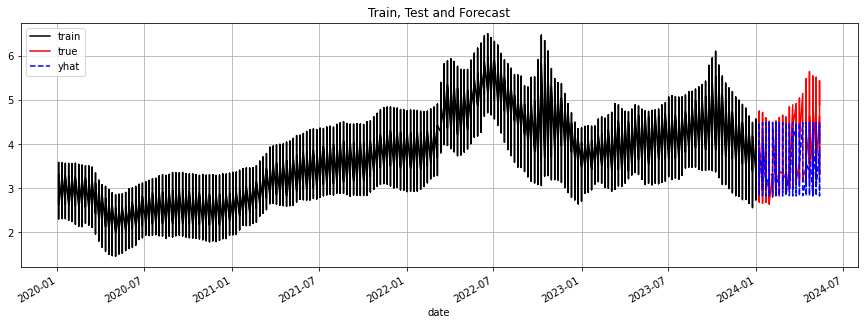

In [ ]:
plot_train_test_forecast(dftp, forecasting, date_col="date", ytrue="price", yhat="yhat");

Out[141]: (<Figure size 1080x720 with 5 Axes>,
 {'r2': -0.7436458109688888,
  'mse': 67.39479942382279,
  'rmse': 8.209433562909368,
  'sred': 101.86400000000012,
  'pv_shap': 0.04027258977293968,
  'pv_norm': 0.034513167220430345,
  'k': 1})

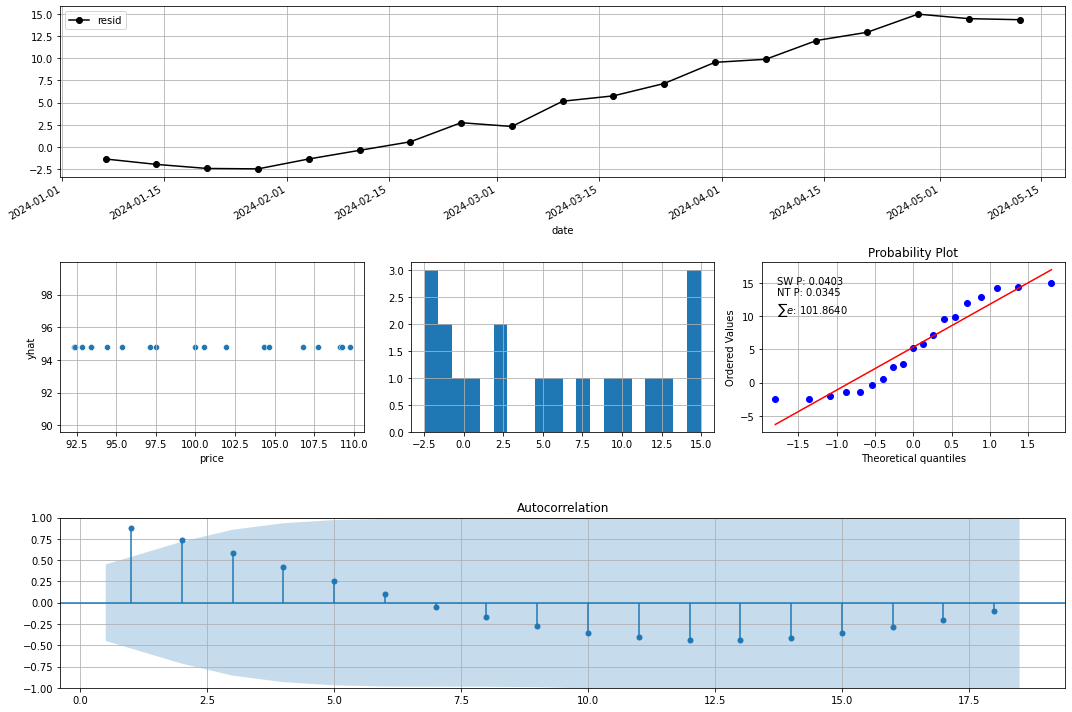

In [ ]:
plot_resid_analysis(
    forecasting,
    x="date",
    ytrue="price",
    yhat="yhat"
)


##### 3.1.1.3. Baseline Future

In [ ]:
forecasting = pd.merge(
    df3[f][["region", "date"]].reset_index(drop=2),
    df3[~f][["region", "date", "price"]].groupby("region").mean("price").reset_index(),
    on="region"
)

forecasting["region"] = forecasting["region"].map({v:k for k, v in region_mapping.items()})
dftp = df_test[["date", "price", "region"]].copy()
dftp["region"] = dftp["region"].map({v:k for k, v in region_mapping.items()})

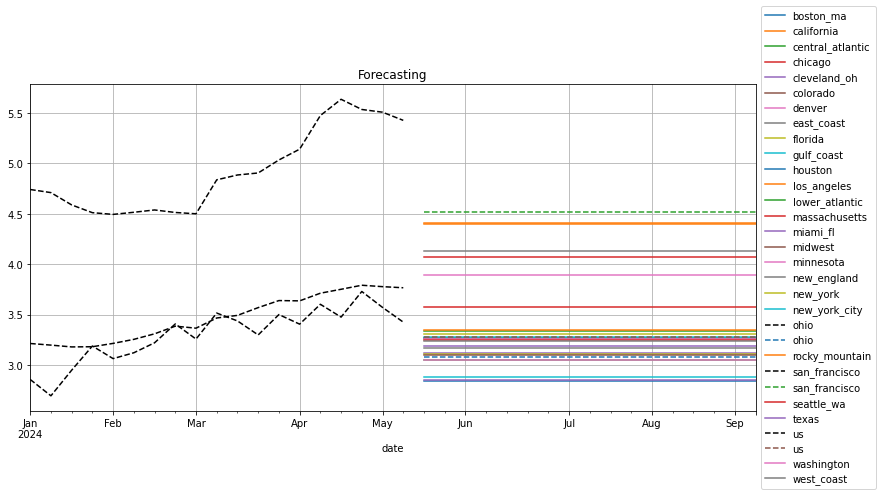

In [ ]:
plot_future_multiple_forecasting(
    df_history=dftp,
    df_forecasting=forecasting,
    target_col="price",
    date_col="date",
    forecasting_col="price",
    unique_id_col="region"
);


#### 3.1.2. StatsForecast

In [ ]:
df_sf = df[~f].copy()
df_sf = df_sf[["region", "date", "price"]]
df_sf.columns = ["unique_id", "ds", "y"]
df_sf["unique_id"] = df_sf["unique_id"].map({v:k for k, v in region_mapping.items()})

df_train = df_sf[df_sf["ds"] < date_train_test_cutoff].reset_index(drop=True)
df_test = df_sf[df_sf["ds"] >= date_train_test_cutoff].reset_index(drop=True)

In [ ]:
df_sf.head()

,unique_id,ds,y
0,boston_ma,2020-01-05,2.643
1,california,2020-01-05,3.517
2,central_atlantic,2020-01-05,2.694
3,chicago,2020-01-05,2.731
4,cleveland_oh,2020-01-05,2.692



##### 3.1.2.1. Base StatsForecast


I can fine tuning seasonal length.

In docs is possbile to see if you have monthly data, "We set season_length to 12 because we expect seasonal effects every 12 months." and references to this post: (https://robjhyndman.com/hyndsight/seasonal-periods/).

For weekly data is expected to get "52" on seasonal length, the gas price "expect" to repat over year, but in plots you can see this pattern changes over time, not like white noise but is litle hard to see a pattern to be captured by any classical statistical forecasting methods that use smoothing or autocorrelated regressors for forecasting, i need a exog features or more regressors to add into account for forecasting.

If I resample the dataset with monthly data, i can try a forecast with seasonal length of 12 istead of try to "fine tuning" the seasonal length.

Classical method selected here is ARIMA, ETS, CES and Theta.

Both ARIMA and ETS need to be analyzed looking at the ACF/PACF and decomposition graphs respectively, but, looking at multiple time series it would be complicated to analyze each time series individually, StatsForecast fits a lot of classical estimators and select a best one for all series.

With previous experience with StatsForecast i suggest to use all classical methods from statsforecast individually for all series because statsforecast try to find a optimal method for all series, ARIMA of statsforecast will not work on this dataset, but sarimax and a more detailed arima from statsmodels can fit one series from this dataset. 

In [ ]:
models = [
    AutoARIMA(
        season_length=7,
        seasonal=True
    ),
    AutoETS(
        season_length=7,
        model="ZZZ"
    ),
    AutoCES(
        season_length=7
    ),
    AutoTheta(
        season_length=7
    )
]

sf = StatsForecast(
    models=models,
    freq="W"
)

description = """
### StatsForecast Fit
Nested Runs have estimators metrics for each run estimator.
I have stored StatsForecast object to mlflow model with all estimators tested inside.
[Github](https://github.com/Nixtla/statsforecast).
"""

In [ ]:
with mlflow.start_run(
    experiment_id=experiment_id,
    run_name="statsforecast-models",
    description=description
) as active_run:
    
    cv_results = cv_mean_baseline(
        df=df_sf,
        model=sf,
        date_col="ds",
        target_col="y"
    )

    desc_metrics = mlflow_log_cv_experiment(cv_results=cv_results, experiment_id=experiment_id)


Logging Model: AutoARIMA
Logging Model: AutoTheta
Logging Model: CES
Logging Model: AutoETS


In [ ]:
desc_metrics

estimator 
 AutoARIMA 
 AutoETS 
 AutoTheta 
 CES 
 
 
 
 count 
 mean 
 std 
 min 
 25% 
 50% 
 75% 
 max 
 count 
 mean 
 std 
 min 
 25% 
 50% 
 75% 
 max 
 count 
 mean 
 std 
 min 
 25% 
 50% 
 75% 
 max 
 count 
 mean 
 std 
 min 
 25% 
 50% 
 75% 
 max 
 
 
 
 
 r2 
 10.0 
 0.354270 
 0.472197 
 -3.714975e-01 
 2.822689e-02 
 4.753933e-01 
 0.761729 
 0.874759 
 10.0 
 0.254265 
 0.559647 
 -5.949602e-01 
 -2.436686e-01 
 4.713750e-01 
 0.684217 
 0.870573 
 10.0 
 0.315459 
 0.537114 
 -9.710854e-01 
 1.957978e-01 
 3.138342e-01 
 0.712410 
 0.882378 
 10.0 
 0.265622 
 0.697438 
 -1.568742e+00 
 2.293265e-01 
 3.020714e-01 
 0.680556 
 0.874799 
 
 
 mse 
 10.0 
 0.213980 
 0.169586 
 3.426182e-02 
 6.518484e-02 
 1.902361e-01 
 0.335951 
 0.526985 
 10.0 
 0.233285 
 0.168507 
 4.007649e-02 
 7.548883e-02 
 2.109437e-01 
 0.372563 
 0.514298 
 10.0 
 0.218487 
 0.150852 
 3.642117e-02 
 8.079485e-02 
 2.446059e-01 
 0.349172 
 0.419117 
 10.0 
 0.224819 
 0.155925 
 3.851697e-02 
 8.079912e-02 
 2.292573e-01 
 0.378839 
 0.407206 
 
 
 rmse 
 10.0 
 0.424633 
 0.193410 
 1.850995e-01 
 2.552470e-01 
 4.341786e-01 
 0.579468 
 0.725937 
 10.0 
 0.449051 
 0.187493 
 2.001911e-01 
 2.721536e-01 
 4.585526e-01 
 0.610379 
 0.717145 
 10.0 
 0.434761 
 0.180955 
 1.908433e-01 
 2.842415e-01 
 4.899650e-01 
 0.590640 
 0.647393 
 10.0 
 0.441156 
 0.183185 
 1.962574e-01 
 2.837476e-01 
 4.759864e-01 
 0.615112 
 0.638127 
 
 
 sred 
 10.0 
 44.693869 
 111.161446 
 -1.622681e+02 
 1.591636e+01 
 5.104903e+01 
 119.255759 
 201.797715 
 10.0 
 61.650621 
 116.891584 
 -1.690769e+02 
 1.462722e+01 
 7.686815e+01 
 147.332734 
 202.364404 
 10.0 
 37.710572 
 125.836151 
 -1.833860e+02 
 9.940276e-01 
 7.160761e+01 
 119.464201 
 175.688021 
 10.0 
 35.773109 
 127.319537 
 -1.794360e+02 
 5.739749e+00 
 7.330800e+01 
 99.765705 
 201.581107 
 
 
 pv_shap 
 10.0 
 0.000105 
 0.000236 
 8.516355e-12 
 8.690911e-10 
 2.654628e-08 
 0.000011 
 0.000712 
 10.0 
 0.000005 
 0.000010 
 1.291735e-16 
 3.911563e-10 
 1.157209e-06 
 0.000003 
 0.000028 
 10.0 
 0.000011 
 0.000023 
 6.975144e-14 
 3.104675e-11 
 2.059440e-07 
 0.000005 
 0.000074 
 10.0 
 0.000014 
 0.000020 
 2.513366e-15 
 9.611733e-11 
 1.183382e-07 
 0.000026 
 0.000051 
 
 
 pv_norm 
 10.0 
 0.008907 
 0.023522 
 3.184377e-21 
 5.289091e-12 
 2.012015e-04 
 0.002827 
 0.075410 
 10.0 
 0.000282 
 0.000779 
 1.604595e-231 
 8.030690e-15 
 1.604056e-07 
 0.000039 
 0.002484 
 10.0 
 0.000826 
 0.002551 
 3.468669e-156 
 9.858122e-16 
 6.255266e-07 
 0.000028 
 0.008086 
 10.0 
 0.000506 
 0.001281 
 1.994679e-153 
 1.968811e-11 
 1.474660e-06 
 0.000058 
 0.004066 
 
 
 k 
 10.0 
 5.500000 
 3.027650 
 1.000000e+00 
 3.250000e+00 
 5.500000e+00 
 7.750000 
 10.000000 
 10.0 
 5.500000 
 3.027650 
 1.000000e+00 
 3.250000e+00 
 5.500000e+00 
 7.750000 
 10.000000 
 10.0 
 5.500000 
 3.027650 
 1.000000e+00 
 3.250000e+00 
 5.500000e+00 
 7.750000 
 10.000000 
 10.0 
 5.500000 
 3.027650 
 1.000000e+00 
 3.250000e+00 
 5.500000e+00 
 7.750000 
 10.000000


##### 3.1.2.2. Base StatsForecast Train & Test

In [ ]:
with mlflow.start_run(
    experiment_id=experiment_id,
    run_name="statsforecast-stats-train-test",
    description=description
) as active_run:
    sf.fit(df_train)
    forecasting = sf.forecast(h=df_test["ds"].nunique()).reset_index()
    forecasting = pd.merge(df_test, forecasting, on=["unique_id", "ds"])
    metrics = pd.DataFrame([get_ml_metrics(forecasting, ytrue="y", yhat=str(m)) | {"estimator": str(m)} for m in sf.models]).drop(columns="k", axis=1)

    for estimator_name in metrics["estimator"].unique():
        with mlflow.start_run(
            nested=True,
            experiment_id=experiment_id,
            run_name=f"{str(estimator_name)}-{str(uuid.uuid1())[:7]}"
        ) as run:
            log_metrics = metrics[metrics["estimator"] == estimator_name].drop(columns="estimator", axis=1).to_dict(orient="records")[0]
            mlflow.log_metrics(log_metrics)

    #mlflow.log_figure(fig, "figs/train_test_forecast.png")
    mlflow.sklearn.log_model(sf, "models/sf_object")


In [ ]:
metrics

,r2,mse,rmse,sred,pv_shap,pv_norm,estimator
0,0.738995,0.101638,0.318808,93.296786,3.919564e-12,3.170874e-09,AutoARIMA
1,0.611847,0.151151,0.388781,140.787896,5.174154e-12,1.884397e-07,AutoETS
2,0.665989,0.130068,0.360649,123.104577,7.091292e-12,1.716515e-07,CES
3,0.722126,0.108207,0.328949,106.777576,2.638142e-12,6.105214e-08,AutoTheta


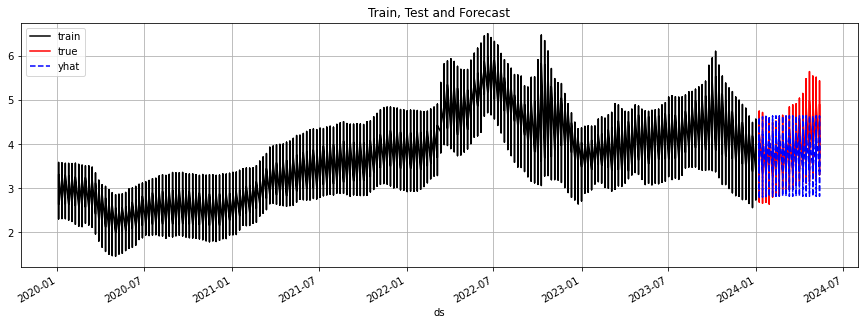

In [ ]:
plot_train_test_forecast(df_train, forecasting, date_col="ds", ytrue="y", yhat="AutoARIMA");

Out[214]: (<Figure size 1080x720 with 5 Axes>,
 {'r2': -0.6006428126714318,
  'mse': 61.86749661574444,
  'rmse': 7.865589400403789,
  'sred': 93.29678149414065,
  'pv_shap': 0.042220182716846466,
  'pv_norm': 0.035479487245127415,
  'k': 1})

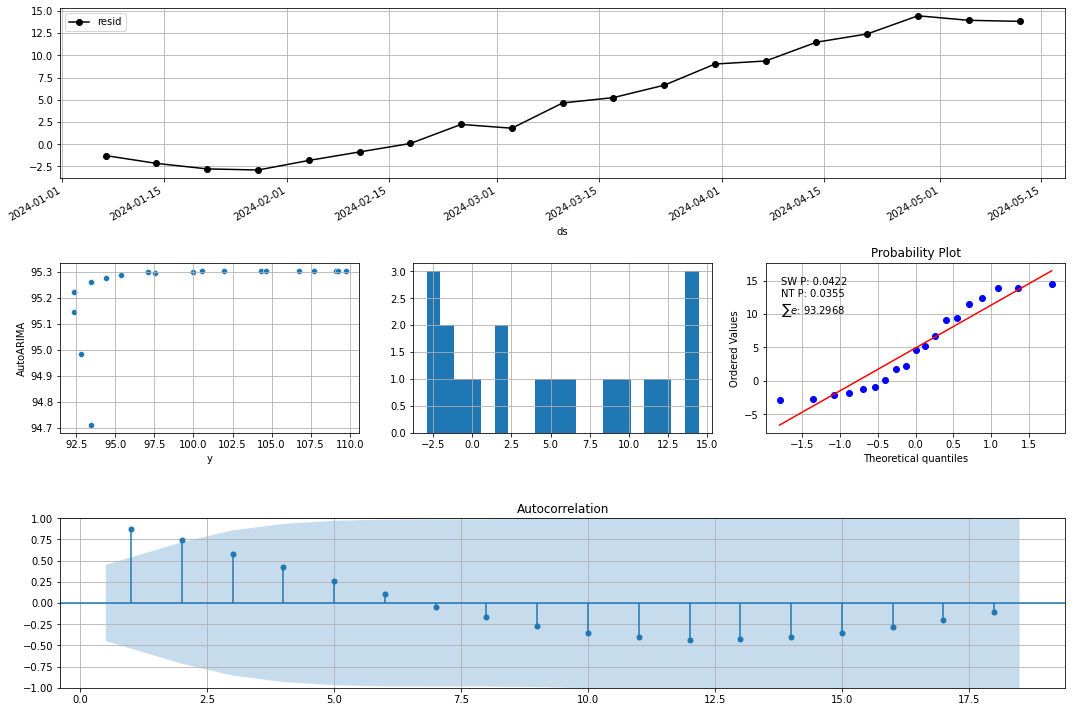

In [ ]:
plot_resid_analysis(
    forecasting,
    x="ds",
    ytrue="y",
    yhat="AutoARIMA"
)


##### 3.1.2.3. Base StatsForecast Future

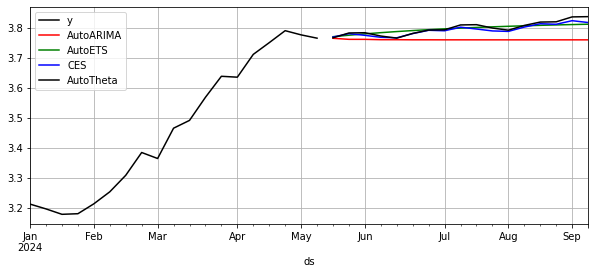

In [ ]:
with mlflow.start_run(
    experiment_id=experiment_id,
    run_name="statsforecast-stats-full",
    description=description
) as active_run:
    sf.fit(df_sf)
    forecasting = sf.forecast(h=df3[f]["date"].nunique()).reset_index()

    fig, ax = plt.subplots(figsize=(10, 4))
    df_sf[(df_sf.unique_id == "us") & (df_sf["ds"] >= "2024-01-01")].plot(x="ds", y="y", color="k", ax=ax)

    for model, color in zip(sf.models, ["r", "g", "b", "k"]):
        forecast_model = forecasting[forecasting.columns[forecasting.columns.str.contains(str(model))].tolist() + ["unique_id", "ds"]]
        forecast_model = forecast_model[forecast_model["unique_id"] == "us"]
        forecast_model.plot(x="ds", y=str(model), ax=ax, grid=2, color=color)

    mlflow.log_figure(fig, "figs/train_test_forecast.png")
    mlflow.sklearn.log_model(sf, "models/sf_object")


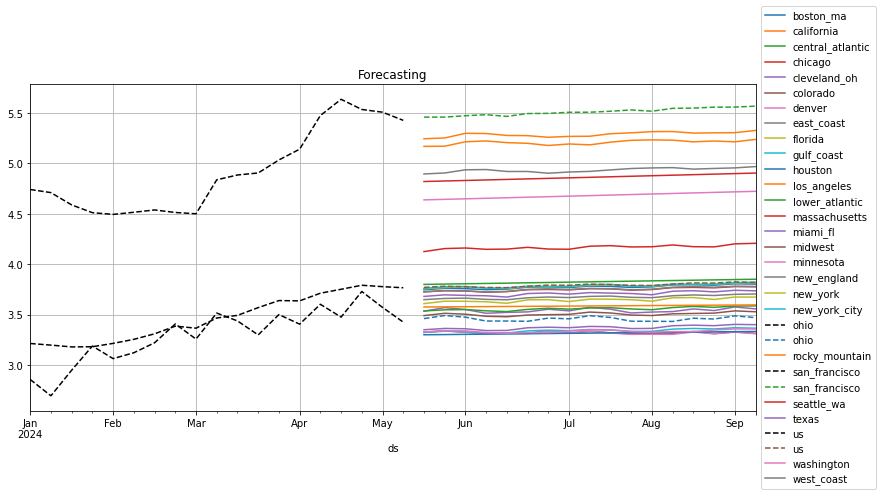

In [ ]:
plot_future_multiple_forecasting(
    df_history=df_sf,
    df_forecasting=forecasting,
    target_col="y",
    forecasting_col="CES"
);


##### 3.1.2.4. Resampling and Seasonal Length


If i try seasonal length of 52, nixtla show error because i do not have complete cyclic period of 52 weeks (i training and validating in a window of 4 months not complete 52 weeks).

The seasonal length in this case can be a hyperparam to tuning but can take a long time.

In [ ]:
models = [
    AutoARIMA(
        season_length=21,
        seasonal=True
    ),
    AutoETS(
        season_length=21,
        model="ZZZ"
    ),
    AutoCES(
        season_length=21
    ),
    AutoTheta(
        season_length=21
    )
]

sf = StatsForecast(
    models=models,
    freq="W"
)

description = """
### StatsForecast Fit
Nested Runs have estimators metrics for each run estimator.
I have stored StatsForecast object to mlflow model with all estimators tested inside.
[Github](https://github.com/Nixtla/statsforecast).
"""

In [ ]:
with mlflow.start_run(
    experiment_id=experiment_id,
    run_name="statsforecast-models",
    description=description
) as active_run:
    
    cv_results = cv_mean_baseline(
        df=df_sf,
        model=sf,
        date_col="ds",
        target_col="y"
    )

    desc_metrics = mlflow_log_cv_experiment(cv_results=cv_results, experiment_id=experiment_id)


Logging Model: AutoARIMA
Logging Model: AutoTheta
Logging Model: CES
Logging Model: AutoETS



With 21 seasonal length, the metrics do not changed a lot, Arima become a bit more wrost than arima with seasonal length of 7 in first fit, but, I suggest to fit individually classical methods for individually series.

In [ ]:
desc_metrics

estimator 
 AutoARIMA 
 AutoETS 
 AutoTheta 
 CES 
 
 
 
 count 
 mean 
 std 
 min 
 25% 
 50% 
 75% 
 max 
 count 
 mean 
 std 
 min 
 25% 
 50% 
 75% 
 max 
 count 
 mean 
 std 
 min 
 25% 
 50% 
 75% 
 max 
 count 
 mean 
 std 
 min 
 25% 
 50% 
 75% 
 max 
 
 
 
 
 r2 
 10.0 
 0.233691 
 0.597014 
 -6.692121e-01 
 -2.985644e-01 
 4.631403e-01 
 0.738805 
 0.872075 
 10.0 
 0.260447 
 0.531291 
 -4.895077e-01 
 -2.679429e-01 
 4.749992e-01 
 0.674734 
 0.864229 
 10.0 
 0.312621 
 0.538138 
 -9.710854e-01 
 1.849870e-01 
 3.071803e-01 
 0.704484 
 0.885424 
 10.0 
 0.172653 
 0.974357 
 -2.513304e+00 
 2.481966e-01 
 3.880074e-01 
 0.612855 
 0.884021 
 
 
 mse 
 10.0 
 0.240954 
 0.179384 
 3.961135e-02 
 6.871499e-02 
 2.433015e-01 
 0.361674 
 0.513521 
 10.0 
 0.234128 
 0.166556 
 4.204087e-02 
 7.547170e-02 
 2.279775e-01 
 0.346675 
 0.512075 
 10.0 
 0.218556 
 0.148583 
 3.547779e-02 
 8.249708e-02 
 2.482438e-01 
 0.355074 
 0.394554 
 10.0 
 0.231551 
 0.165025 
 3.591218e-02 
 1.077384e-01 
 2.364443e-01 
 0.316564 
 0.553682 
 
 
 rmse 
 10.0 
 0.452397 
 0.200806 
 1.990260e-01 
 2.618802e-01 
 4.928485e-01 
 0.601393 
 0.716604 
 10.0 
 0.450778 
 0.185372 
 2.050387e-01 
 2.728436e-01 
 4.774174e-01 
 0.588776 
 0.715594 
 10.0 
 0.435210 
 0.179964 
 1.883555e-01 
 2.872200e-01 
 4.942263e-01 
 0.595669 
 0.628136 
 10.0 
 0.448812 
 0.182937 
 1.895051e-01 
 3.281372e-01 
 4.826472e-01 
 0.562641 
 0.744098 
 
 
 sred 
 10.0 
 48.807123 
 115.753805 
 -1.688243e+02 
 1.360411e+01 
 4.755826e+01 
 132.878934 
 197.963739 
 10.0 
 61.369484 
 118.136496 
 -1.606615e+02 
 1.871214e+01 
 7.390882e+01 
 149.043630 
 201.636550 
 10.0 
 39.385586 
 124.384080 
 -1.704365e+02 
 -1.931809e+00 
 7.026796e+01 
 124.186773 
 175.688021 
 10.0 
 47.125528 
 123.864517 
 -1.624853e+02 
 1.631168e+01 
 7.617773e+01 
 98.969153 
 243.093345 
 
 
 pv_shap 
 10.0 
 0.000033 
 0.000096 
 1.897762e-15 
 3.271166e-08 
 1.076198e-07 
 0.000007 
 0.000306 
 10.0 
 0.000010 
 0.000020 
 2.848846e-16 
 6.077890e-09 
 1.312109e-07 
 0.000010 
 0.000060 
 10.0 
 0.000027 
 0.000062 
 2.796100e-14 
 2.646994e-11 
 1.711783e-08 
 0.000003 
 0.000191 
 10.0 
 0.000001 
 0.000002 
 3.940175e-13 
 1.713917e-09 
 9.204326e-09 
 0.000002 
 0.000005 
 
 
 pv_norm 
 10.0 
 0.000769 
 0.002163 
 1.478938e-21 
 5.830059e-09 
 1.628257e-06 
 0.000039 
 0.006891 
 10.0 
 0.000740 
 0.001760 
 5.297470e-217 
 1.112053e-14 
 1.411951e-09 
 0.000021 
 0.005446 
 10.0 
 0.003074 
 0.009489 
 3.162490e-163 
 9.053891e-16 
 2.769770e-10 
 0.000087 
 0.030075 
 10.0 
 0.000163 
 0.000422 
 3.801913e-43 
 1.660999e-11 
 1.113260e-07 
 0.000038 
 0.001348 
 
 
 k 
 10.0 
 5.500000 
 3.027650 
 1.000000e+00 
 3.250000e+00 
 5.500000e+00 
 7.750000 
 10.000000 
 10.0 
 5.500000 
 3.027650 
 1.000000e+00 
 3.250000e+00 
 5.500000e+00 
 7.750000 
 10.000000 
 10.0 
 5.500000 
 3.027650 
 1.000000e+00 
 3.250000e+00 
 5.500000e+00 
 7.750000 
 10.000000 
 10.0 
 5.500000 
 3.027650 
 1.000000e+00 
 3.250000e+00 
 5.500000e+00 
 7.750000 
 10.000000


##### 3.1.2.5. MSTL


The MSTL model (Multiple Seasonal-Trend decomposition using LOESS) is a method used to decompose a time series into its seasonal, trend and residual components. This approach is based on the use of LOESS (Local Regression Smoothing) to estimate the components of the time series.

The MSTL decomposition is an extension of the classic seasonal-trend decomposition method (also known as Holt-Winters decomposition), which is designed to handle situations where multiple seasonal patterns exist in the data. This can occur, for example, when a time series exhibits daily, weekly, and yearly patterns simultaneously.

Traditionally, STL is the best decomposition model for time series in classic methods (https://otexts.com/fpp2/stl.html), MSTL use STL to decompose and forecasting, but i need to forecast the components of the series, maybe can be very hard too (https://otexts.com/fpp2/complexseasonality.html).

I will use this method from nixtla package:

- https://nixtlaverse.nixtla.io/statsforecast/docs/tutorials/multipleseasonalities.html

In [ ]:
models = [
    MSTL(
        # STL support multiple or high seasonality
        season_length=[52],

        # Forecasting Trend component with Arima.
        trend_forecaster=AutoARIMA()
    )
]

sf = StatsForecast(models=models, freq="W")

description = """
### StatsForecast Fit
MSTL Training with multiple arbitrary seasonal lengths
[Github](https://nixtlaverse.nixtla.io/statsforecast/docs/tutorials/multipleseasonalities.html).
"""

In [ ]:
with mlflow.start_run(
    experiment_id=experiment_id,
    run_name="statsforecast-models",
    description=description
) as active_run:
    
    cv_results = cv_mean_baseline(
        df=df_sf,
        model=sf,
        date_col="ds",
        target_col="y"
    )

    desc_metrics = mlflow_log_cv_experiment(cv_results=cv_results, experiment_id=experiment_id)


Logging Model: MSTL



The metrics change a bit, lets try a full fit and future forecasting.

In [ ]:
desc_metrics

estimator 
 MSTL 
 
 
 
 count 
 mean 
 std 
 min 
 25% 
 50% 
 75% 
 max 
 
 
 
 
 r2 
 10.0 
 -0.568205 
 1.059417 
 -2.154775e+00 
 -1.341726e+00 
 -3.158048e-01 
 0.236156 
 0.785661 
 
 
 mse 
 10.0 
 0.418052 
 0.200855 
 1.121008e-01 
 2.961207e-01 
 3.949767e-01 
 0.565425 
 0.742637 
 
 
 rmse 
 10.0 
 0.627030 
 0.166281 
 3.348146e-01 
 5.429178e-01 
 6.284656e-01 
 0.751529 
 0.861764 
 
 
 sred 
 10.0 
 22.121238 
 203.425873 
 -2.578792e+02 
 -1.746515e+02 
 9.313521e+01 
 172.495214 
 262.800275 
 
 
 pv_shap 
 10.0 
 0.000024 
 0.000060 
 3.853592e-16 
 3.700879e-10 
 4.107236e-07 
 0.000003 
 0.000190 
 
 
 pv_norm 
 10.0 
 0.001975 
 0.004455 
 3.952093e-60 
 1.023789e-17 
 3.008404e-06 
 0.000950 
 0.014218 
 
 
 k 
 10.0 
 5.500000 
 3.027650 
 1.000000e+00 
 3.250000e+00 
 5.500000e+00 
 7.750000 
 10.000000


##### 3.1.2.6. MSTL Train & Test

In [ ]:
with mlflow.start_run(
    experiment_id=experiment_id,
    run_name="statsforecast-mstl-train-test",
    description=description
) as active_run:
    sf.fit(df_train)
    forecasting = sf.forecast(h=df_test["ds"].nunique()).reset_index()
    forecasting = pd.merge(df_test, forecasting, on=["unique_id", "ds"])
    metrics = pd.DataFrame([get_ml_metrics(forecasting, ytrue="y", yhat=str(m)) | {"estimator": str(m)} for m in sf.models]).drop(columns="k", axis=1)

    for estimator_name in metrics["estimator"].unique():
        with mlflow.start_run(
            nested=True,
            experiment_id=experiment_id,
            run_name=f"{str(estimator_name)}-{str(uuid.uuid1())[:7]}"
        ) as run:
            log_metrics = metrics[metrics["estimator"] == estimator_name].drop(columns="estimator", axis=1).to_dict(orient="records")[0]
            mlflow.log_metrics(log_metrics)

    #mlflow.log_figure(fig, "figs/train_test_forecast.png")
    mlflow.sklearn.log_model(sf, "models/sf_object")


In [ ]:
metrics

,r2,mse,rmse,sred,pv_shap,pv_norm,estimator
0,0.616644,0.149283,0.386372,-161.423731,1.663027e-16,1.142577e-25,MSTL


Out[223]: (<Figure size 1080x720 with 5 Axes>,
 {'r2': -1.0742205520510644,
  'mse': 80.17206085482155,
  'rmse': 8.953885237974717,
  'sred': -161.4237308959961,
  'pv_shap': 0.14646337926387787,
  'pv_norm': 0.07393836644365522,
  'k': 1})

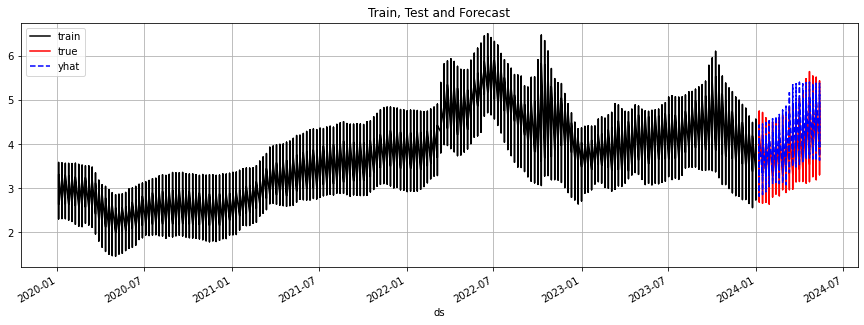

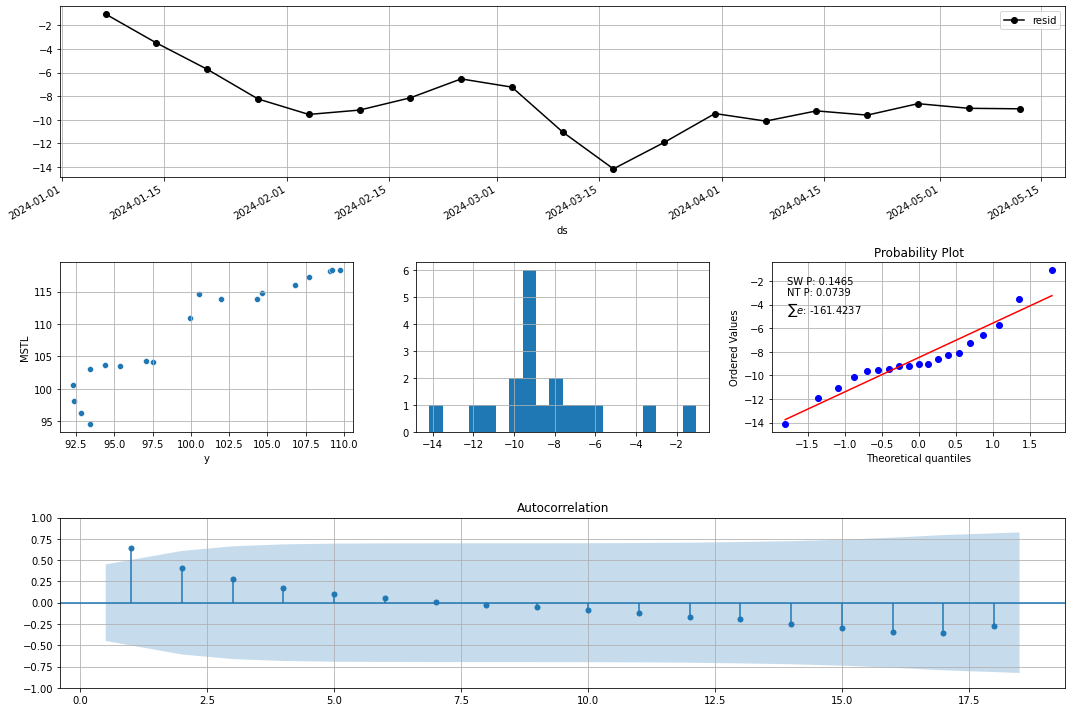

In [ ]:
plot_train_test_forecast(df_train, forecasting, date_col="ds", ytrue="y", yhat="MSTL");

plot_resid_analysis(
    forecasting,
    x="ds",
    ytrue="y",
    yhat="MSTL"
)


##### 3.1.2.7. MSTL Future Forecasting

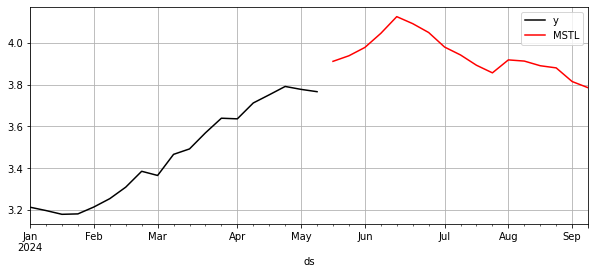

In [ ]:
with mlflow.start_run(
    experiment_id=experiment_id,
    run_name="statsforecast-mstl-full",
    description=description
) as active_run:
    sf.fit(df_sf)
    forecasting = sf.forecast(h=df3[f]["date"].nunique()).reset_index()

    fig, ax = plt.subplots(figsize=(10, 4))
    df_sf[(df_sf.unique_id == "us") & (df_sf["ds"] >= "2024-01-01")].plot(x="ds", y="y", color="k", ax=ax)

    for model, color in zip(sf.models, ["r", "g", "b"]):
        forecast_model = forecasting[forecasting.columns[forecasting.columns.str.contains(str(model))].tolist() + ["unique_id", "ds"]]
        forecast_model = forecast_model[forecast_model["unique_id"] == "us"]
        forecast_model.plot(x="ds", y=str(model), ax=ax, grid=2, color=color)

    mlflow.log_figure(fig, "figs/train_test_forecast.png")
    mlflow.sklearn.log_model(sf, "models/sf_object")



Looks like very good future forecasting with classical methods, two key points in my opinion:

- None Feature Engineering, just "give-me the series and I will forecast";
- Support for multiple seasonality.

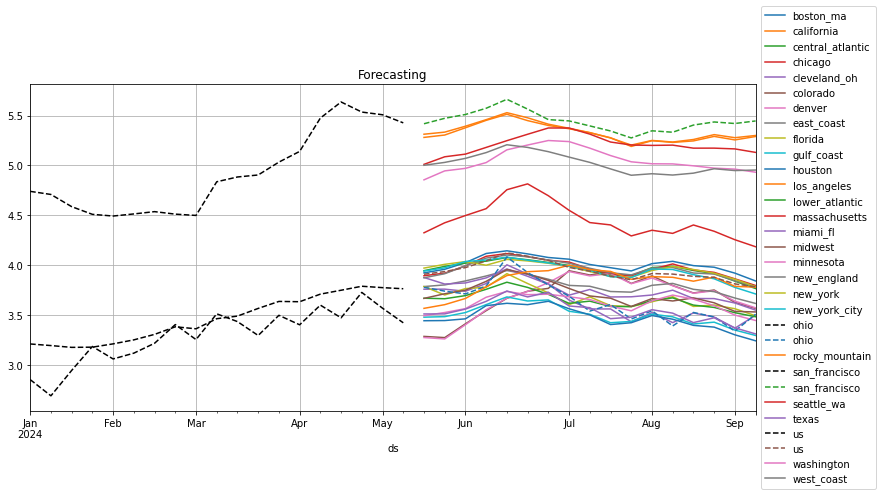

In [ ]:
plot_future_multiple_forecasting(
    df_history=df_sf,
    df_forecasting=forecasting,
    target_col="y",
    forecasting_col="MSTL"
);

In [ ]:
print(f"Model Run Id: {active_run.info.run_uuid}")

sf_loaded = mlflow.pyfunc.load_model(
    f"runs:/{active_run.info.run_uuid}/models/sf_object"
)

sf_loaded.predict(1).head()

Model Run Id: f468cab04a9e4371a71a9a68c9d459bf


,ds,MSTL
unique_id,,
boston_ma,2024-05-19,3.924873
california,2024-05-19,5.313227
central_atlantic,2024-05-19,3.946774
chicago,2024-05-19,4.326187
cleveland_oh,2024-05-19,3.761247



#### 3.1.3. MLForecast


MLForecast is a very great tool for forecasting with Machine Learning, you can use optuna too for fine tuning the estimators and create a infitite possibility of new features just mapping on a list. (https://forecastegy.com/posts/multiple-time-series-forecasting-with-lightgbm-in-python/).

In [ ]:
mlflow.autolog(disable=True)


##### 3.1.3.1. Base MlForecast

In [ ]:
mlf = MLForecast(
    freq="W",
    models=[
        KNeighborsRegressor(
            n_neighbors=10
        ),
        DecisionTreeRegressor(
            max_leaf_nodes=20
        )
    ],
    target_transforms=[
        Differences([7])
    ],
    lag_transforms={ 
        17: [
            (rolling_mean, 2),
            (rolling_mean, 3),
            (ewm_mean, 0.9),
            expanding_mean,
            (rolling_min,7),
            (rolling_max,7),
            (rolling_std,2),
            (rolling_std,3),
        ],
    },
    lags=[2, 3, 4 ,5], #, 14, 21, 28],
    date_features=[
        "month",
        "year",
        "day_of_week",
        "day_of_year",
        "is_month_start",
        "quarter",
        "days_in_month"
    ],
    num_threads=4
)

description = """
### MLForecast Fit
Nested Runs have estimators metrics for each run estimator.
I have stored MLForecast object to mlflow model with all estimators tested inside.
[Github](https://github.com/Nixtla/mlforecast).
"""

In [ ]:
with mlflow.start_run(
    experiment_id=experiment_id,
    run_name="mlforecast-models",
    description=description
) as active_run:
    
    cv_results = cv_mean_baseline(
        df=df_sf,
        model=mlf,
        date_col="ds",
        target_col="y"
    )

    desc_metrics = mlflow_log_cv_experiment(cv_results=cv_results, experiment_id=experiment_id)

Logging Model: DecisionTreeRegressor
Logging Model: KNeighborsRegressor


In [ ]:
desc_metrics

estimator 
 DecisionTreeRegressor 
 KNeighborsRegressor 
 
 
 
 count 
 mean 
 std 
 min 
 25% 
 50% 
 75% 
 max 
 count 
 mean 
 std 
 min 
 25% 
 50% 
 75% 
 max 
 
 
 
 
 r2 
 10.0 
 -0.440944 
 1.385916 
 -3.823143e+00 
 -7.023651e-01 
 -4.641579e-01 
 0.589188 
 0.872183 
 10.0 
 0.263599 
 0.612727 
 -9.521190e-01 
 -1.725580e-01 
 4.485345e-01 
 0.723072 
 0.907454 
 
 
 mse 
 10.0 
 0.487245 
 0.549182 
 2.556908e-02 
 1.337047e-01 
 3.581029e-01 
 0.510235 
 1.877359 
 10.0 
 0.262540 
 0.247849 
 1.851335e-02 
 7.862025e-02 
 1.746238e-01 
 0.401160 
 0.793272 
 
 
 rmse 
 10.0 
 0.613516 
 0.350940 
 1.599034e-01 
 3.577309e-01 
 5.977956e-01 
 0.713127 
 1.370167 
 10.0 
 0.457778 
 0.242621 
 1.360638e-01 
 2.803916e-01 
 4.111982e-01 
 0.633242 
 0.890658 
 
 
 sred 
 10.0 
 -32.014655 
 186.612518 
 -3.545588e+02 
 -1.466041e+02 
 4.901490e+00 
 109.350545 
 180.092951 
 10.0 
 -30.985610 
 119.145999 
 -2.874451e+02 
 -8.752540e+01 
 1.236845e+01 
 52.583425 
 81.398700 
 
 
 pv_shap 
 10.0 
 0.002537 
 0.007835 
 1.341641e-18 
 2.555220e-08 
 6.799821e-07 
 0.000003 
 0.024832 
 10.0 
 0.000315 
 0.000815 
 1.346472e-13 
 4.429666e-08 
 1.947663e-07 
 0.000128 
 0.002608 
 
 
 pv_norm 
 10.0 
 0.004736 
 0.013678 
 2.032752e-33 
 6.257137e-10 
 1.035539e-05 
 0.000824 
 0.043596 
 10.0 
 0.000674 
 0.002009 
 1.434193e-27 
 8.731538e-08 
 6.467280e-06 
 0.000063 
 0.006389 
 
 
 k 
 10.0 
 5.500000 
 3.027650 
 1.000000e+00 
 3.250000e+00 
 5.500000e+00 
 7.750000 
 10.000000 
 10.0 
 5.500000 
 3.027650 
 1.000000e+00 
 3.250000e+00 
 5.500000e+00 
 7.750000 
 10.000000


#### 3.1.4. Sklearn


With SKlearn or any other basemodel with train and predict class is possible to future forecasting too.

In [ ]:
df_train.drop(columns="future", inplace=True)
df_test.drop(columns="future", inplace=True)

In [ ]:
x_train = df_train.drop(columns=["price", "date"], axis=1)
y_train = df_train["price"].values

x_test = df_test.drop(columns=["price", "date"], axis=1)
y_test = df_test["price"].values

In [ ]:
x_train.head()

,region,lag_4_months,lag_5_months,lag_12_months_plus,lag_12_months,lag_12_months_minus,diff_4_months,diff_5_months,diff_12_months_plus,diff_12_months,diff_12_months_minus,latitude,longitude,day,year,month,quarter,week,day_sin,day_cos,week_sin,week_cos,month_sin,month_cos,quarter_sin,quarter_cos
0,0,2.739,2.806,2.651,2.603,2.539,-0.741,0.139,0.160,0.476,0.146,42.367970,-71.052616,5,2020,1,1,1,0.866025,0.5,0.120537,0.992709,0.5,0.866025,1.0,6.123234e-17
1,1,3.569,3.625,3.332,3.296,3.261,1.151,0.880,1.127,0.823,0.909,36.701463,-118.755997,5,2020,1,1,1,0.866025,0.5,0.120537,0.992709,0.5,0.866025,1.0,6.123234e-17
2,2,2.697,2.853,2.530,2.491,2.467,-0.026,0.167,-0.023,0.065,0.094,47.590493,-122.324313,5,2020,1,1,1,0.866025,0.5,0.120537,0.992709,0.5,0.866025,1.0,6.123234e-17
3,3,2.879,3.193,2.346,2.239,2.237,0.410,0.661,-0.143,-0.189,-0.032,41.875562,-87.624421,5,2020,1,1,1,0.866025,0.5,0.120537,0.992709,0.5,0.866025,1.0,6.123234e-17
4,4,2.622,2.762,2.102,2.014,2.011,0.070,0.192,-0.357,-0.318,-0.040,41.539417,-81.635238,5,2020,1,1,1,0.866025,0.5,0.120537,0.992709,0.5,0.866025,1.0,6.123234e-17



##### 3.1.4.1. Decision Tree

         r2      mse      rmse       sred       pv_shap   pv_norm  k
0  0.607407  0.15288  0.390999 -67.437129  2.194952e-08  0.000019  1


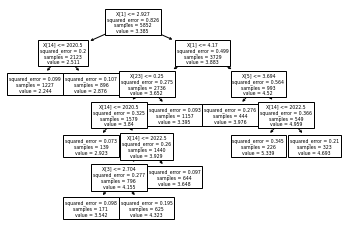

In [ ]:
with mlflow.start_run(
    experiment_id=experiment_id,
    run_name="forecasting-dtr-basic"
) as active_run:
    dtr = DecisionTreeRegressor(
        min_samples_leaf=20,
        max_leaf_nodes=10
    )

    dtr.fit(x_train, y_train)
    yhat = dtr.predict(x_test)

    forecasting = pd.DataFrame({"yhat": yhat, "price": y_test, "date": df_test["date"].values})
    metrics = get_ml_metrics(forecasting, ytrue="price", yhat="yhat")

    fig = plot_tree(dtr);
    print(pd.DataFrame(metrics, index=[0]))

    mlflow.log_metrics(metrics)

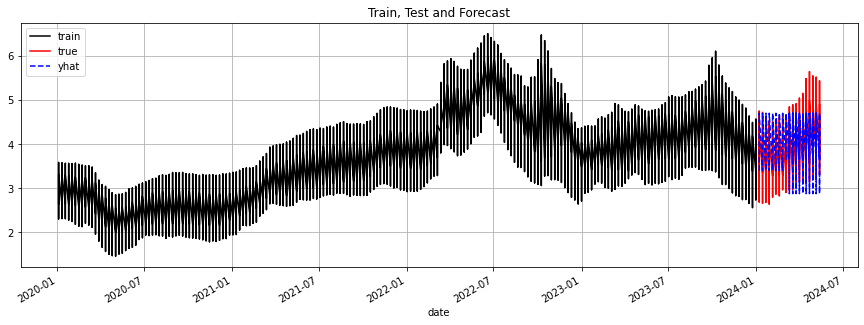

In [ ]:
plot_train_test_forecast(
    df_train,
    forecasting,
    date_col="date",
    ytrue="price",
    yhat="yhat"
);

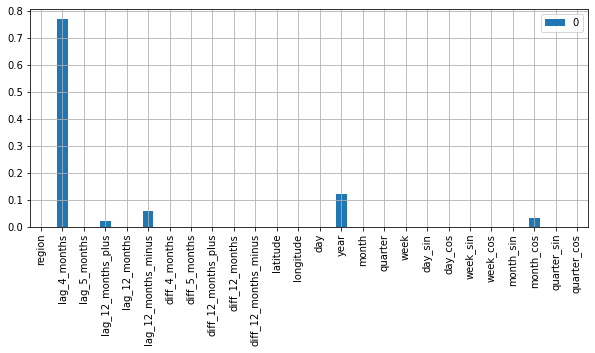

In [ ]:
pd.DataFrame({k: v for k, v in zip(x_train.columns, dtr.feature_importances_)}, index=[0]).T.plot(kind="bar", grid=2, figsize=(10, 4));

Out[82]: (<Figure size 1080x720 with 5 Axes>,
 {'r2': -0.7360704735894874,
  'mse': 67.1020000834746,
  'rmse': 8.191581049069502,
  'sred': -67.43712914604535,
  'pv_shap': 0.009572372771799564,
  'pv_norm': 0.20336339610246712,
  'k': 1})

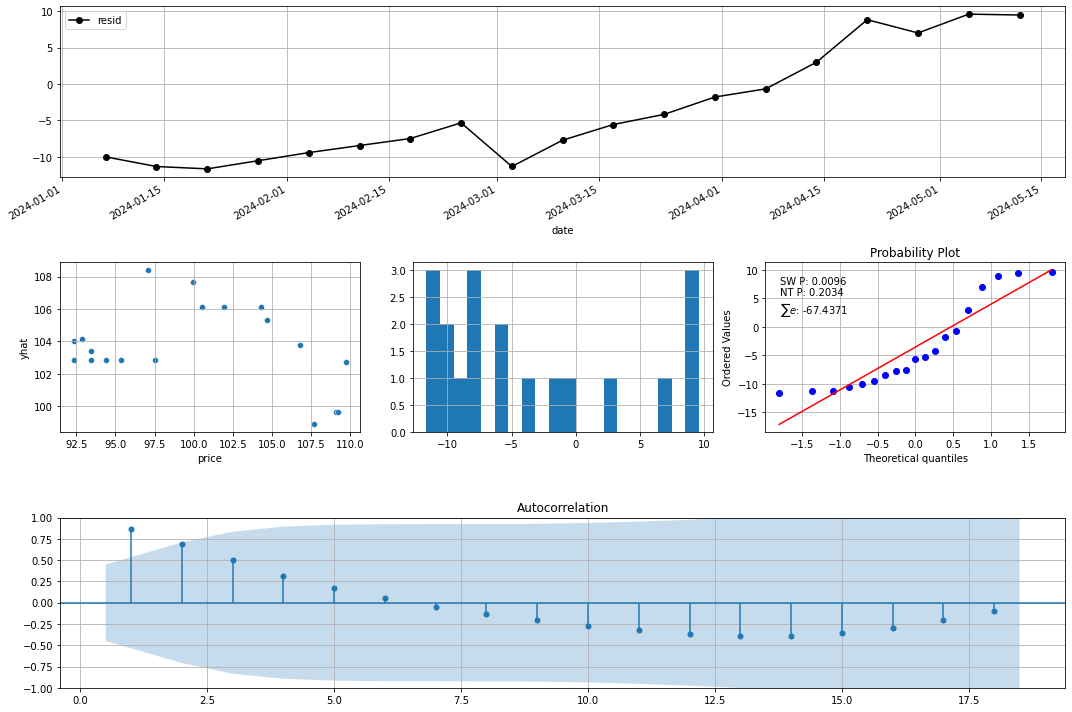

In [ ]:
plot_resid_analysis(forecasting, ytrue="price", yhat="yhat")


##### 3.1.4.2. XGBoost

In [ ]:
with mlflow.start_run(
    experiment_id=experiment_id,
    run_name="forecasting-xgb-basic"
) as active_run:
    xgb = XGBRegressor(
        objective="reg:squarederror",
        n_estimators=50,
        max_depth=5
    )

    xgb.fit(x_train, y_train, verbose=True)
    yhat = xgb.predict(x_test)

    forecasting = pd.DataFrame({"yhat": yhat, "price": y_test, "date": df_test["date"].values})
    metrics = get_ml_metrics(forecasting, ytrue="price", yhat="yhat")
    print(pd.DataFrame(metrics, index=[0]))

    mlflow.log_metrics(metrics)

         r2       mse      rmse      sred   pv_shap   pv_norm  k
0  0.795026  0.079819  0.282523 -58.74309  0.000191  0.002657  1


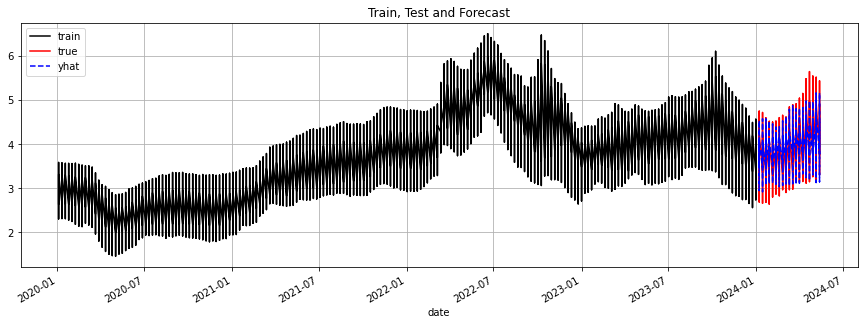

In [ ]:
plot_train_test_forecast(
    df_train,
    forecasting,
    date_col="date",
    ytrue="price",
    yhat="yhat"
);

Out[85]: (<Figure size 1080x720 with 5 Axes>,
 {'r2': 0.3166234524874584,
  'mse': 26.413635762965168,
  'rmse': 5.139419788552514,
  'sred': -58.743082092285135,
  'pv_shap': 0.1507437378168106,
  'pv_norm': 0.14738654766839196,
  'k': 1})

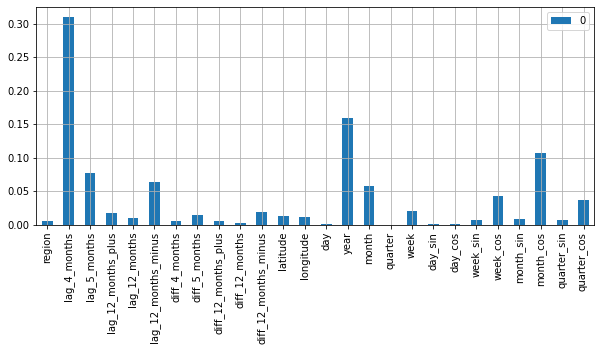

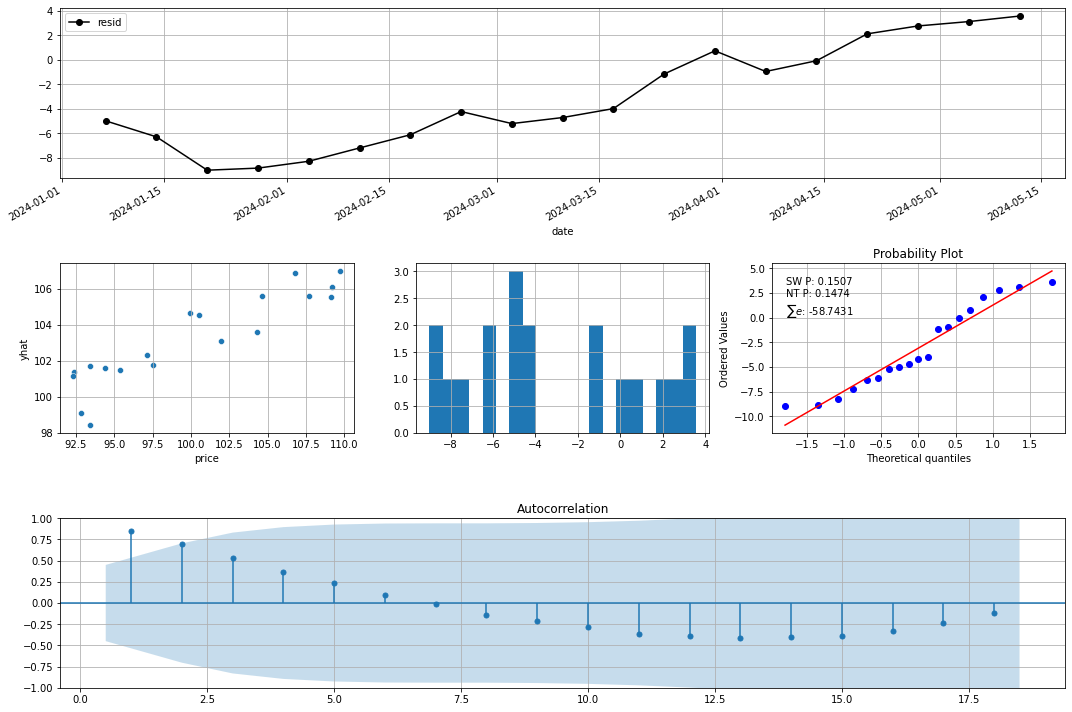

In [ ]:
pd.DataFrame(xgb.feature_importances_, xgb.feature_names_in_).plot(kind="bar", grid=2, figsize=(10, 4));

plot_resid_analysis(forecasting)


Lets take a look at "default" (or with minimal params) XGBoost forecastings in future with a full training.

In [ ]:
forecasting = df3[f].copy()
dftp = df_test.copy()

with mlflow.start_run(
    experiment_id=experiment_id,
    run_name="forecasting-xgb-basic-full"
) as active_run:
    
    xgb = XGBRegressor(
        objective="reg:squarederror",
        n_estimators=50,
        max_depth=5
    )

    xgb.fit(df3[~f].drop(columns=["date", "price", "future"]), df3[~f]["price"])

    mlflow.sklearn.log_model(xgb, "models/xgb_object")

In [ ]:
print(f"Model Run Id: {active_run.info.run_uuid}")

xgb_loaded = mlflow.pyfunc.load_model(
    f"runs:/{active_run.info.run_uuid}/models/xgb_object"
)

Model Run Id: c224e22d1a004fd98355dafc572d8a71


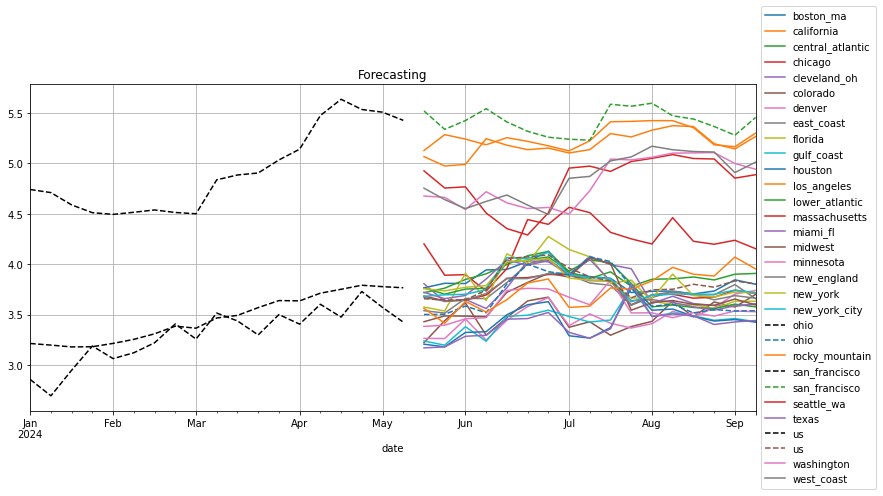

In [ ]:
yhat = xgb_loaded.predict(forecasting[xgb.feature_names_in_])

forecasting["price"] = yhat
forecasting["region"] = forecasting.region.map({v:k for k, v in region_mapping.items()})
dftp["region"] = dftp.region.map({v:k for k, v in region_mapping.items()})

plot_future_multiple_forecasting(
    df_history=dftp,
    df_forecasting=forecasting,
    target_col="price",
    date_col="date",
    forecasting_col="price",
    unique_id_col="region"
);


##### 3.1.4.3. XGBoost Cross Validation

In [ ]:
with mlflow.start_run(
    experiment_id=experiment_id,
    run_name="forecasting-xgb-cv-basic"
) as active_run:
    xgb = XGBRegressor(
        objective="reg:squarederror",
        n_estimators=50,
        max_depth=5
    )

    metrics = cv_mean_baseline(df_train, model=xgb, base_sklearn=True)
    log_mean_metrics, log_std_metrics, desc_metrics, k_fold_metrics = describe_ml_metrics(metrics)
    log_mean_metrics[0].pop("estimator")
    log_std_metrics[0].pop("estimator")

    mlflow.log_metrics(log_mean_metrics[0])
    mlflow.log_metrics(log_std_metrics[0])


In [ ]:
desc_metrics

estimator 
 base 
 
 
 
 count 
 mean 
 std 
 min 
 25% 
 50% 
 75% 
 max 
 
 
 
 
 r2 
 9.0 
 -0.959578 
 1.734109 
 -4.308361e+00 
 -2.454632e+00 
 -2.997625e-01 
 1.844167e-01 
 0.778584 
 
 
 mse 
 9.0 
 0.530364 
 0.299922 
 6.266875e-02 
 4.185356e-01 
 5.203390e-01 
 7.127210e-01 
 0.919295 
 
 
 rmse 
 9.0 
 0.689910 
 0.247360 
 2.503373e-01 
 6.469433e-01 
 7.213453e-01 
 8.442280e-01 
 0.958799 
 
 
 sred 
 9.0 
 20.262866 
 288.885509 
 -3.855898e+02 
 -1.595826e+02 
 8.949237e+00 
 2.543941e+02 
 391.043351 
 
 
 pv_shap 
 9.0 
 0.000023 
 0.000070 
 1.521715e-18 
 1.005427e-13 
 3.249849e-10 
 1.404485e-08 
 0.000210 
 
 
 pv_norm 
 9.0 
 0.018227 
 0.054682 
 2.666858e-50 
 4.964206e-23 
 5.736374e-18 
 6.138802e-11 
 0.164046 
 
 
 k 
 9.0 
 5.000000 
 2.738613 
 1.000000e+00 
 3.000000e+00 
 5.000000e+00 
 7.000000e+00 
 9.000000


##### 3.1.4.4. XGBoost Fine Tuning


XGBoost fine tuning.

- n_estimators: Number of trees into boosting ensemble.
- learning_rate: Value between 0 and 1 to slow down trees growing.
- min_child_weight: Value to prevent tree leaf to be partitioned again, (maybe you will get truncated nodes).
- max_depth: Max depth of tree can grow, (maybe you will get unbalanced trees).
- reg_alpha: L1 Reg param, slow down not important trees.
- reg_lambda: L2 Reg Param, slow down tree weights.

In [ ]:
def objective(trial):
    params = {
        "objective": "reg:squarederror",
        "n_estimators": trial.suggest_int("n_estimators", 25, 50),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "reg_alpha": trial.suggest_int("reg_alpha", 0, 10),
        "reg_lambda": trial.suggest_int("reg_lambda", 0, 10),
    }

    xgb = XGBRegressor(**params)
    metrics = cv_mean_baseline(df_train, model=xgb, base_sklearn=True)
    log_mean_metrics, log_std_metrics, desc_metrics, k_fold_metrics = describe_ml_metrics(metrics)

    return desc_metrics["base"]["mean"].loc["rmse"]

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

In [ ]:
print(study.best_value)

print(study.best_params)

0.6853094651767956
{'n_estimators': 44, 'learning_rate': 0.08966770501499931, 'min_child_weight': 6, 'max_depth': 5, 'reg_alpha': 0, 'reg_lambda': 8}


In [ ]:
with mlflow.start_run(
    experiment_id=experiment_id,
    run_name="forecasting-xgb-full"
) as active_run:
    xgb = XGBRegressor(**study.best_params)
    xgb.fit(x_train, y_train)
    yhat = xgb.predict(x_test)

    forecasting = pd.DataFrame({"yhat": yhat, "price": y_test, "date": df_test["date"].values})
    metrics = get_ml_metrics(forecasting, ytrue="price", yhat="yhat")
    print(pd.DataFrame(metrics, index=[0]))

    mlflow.log_metrics(metrics)
    mlflow.sklearn.log_model(xgb, "models/xgb_object")

         r2       mse      rmse       sred   pv_shap   pv_norm  k
0  0.801977  0.077113  0.277692 -45.363861  0.000332  0.004183  1


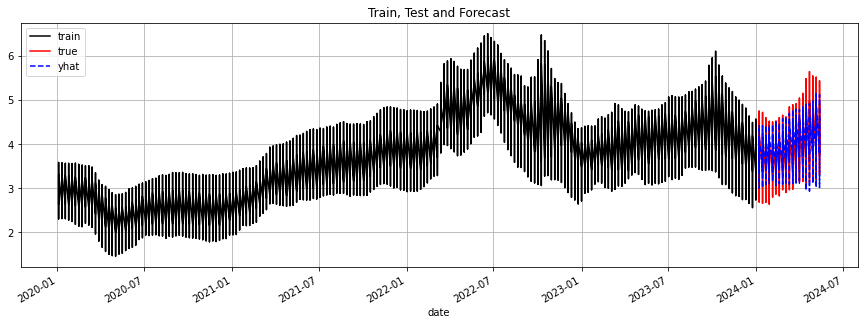

In [ ]:
plot_train_test_forecast(
    df_train,
    forecasting,
    date_col="date",
    ytrue="price",
    yhat="yhat"
);

Out[98]: (<Figure size 1080x720 with 5 Axes>,
 {'r2': 0.3510503136392964,
  'mse': 25.082980541862288,
  'rmse': 5.008291179819948,
  'sred': -45.36387829589842,
  'pv_shap': 0.04512302577495575,
  'pv_norm': 0.2305919979334368,
  'k': 1})

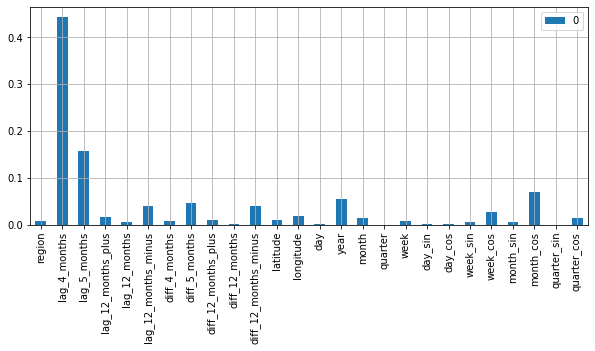

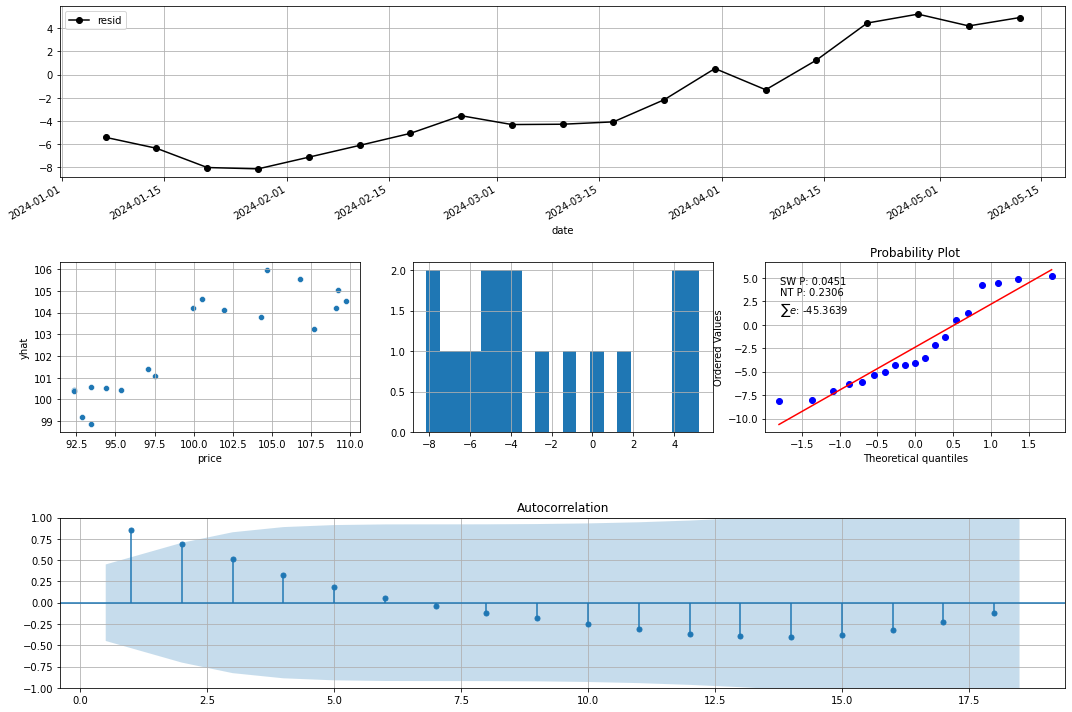

In [ ]:
pd.DataFrame(xgb.feature_importances_, xgb.feature_names_in_).plot(kind="bar", grid=2, figsize=(10, 4));

plot_resid_analysis(forecasting)

In [ ]:
with mlflow.start_run(
    experiment_id=experiment_id,
    run_name="forecasting-xgb-full-deploy"
) as active_run:
    xgb = XGBRegressor(**study.best_params)
    xgb.fit(df3[~f].drop(columns=["date", "price", "future"]), df3[~f]["price"])
    mlflow.sklearn.log_model(xgb, "models/xgb_object")


##### 3.1.4.5. XGBoost Future Forecasting


The standard xgb created previously has forecasts for the 4 months that are more realistic than the tuned XGB, maybe one of extra params have a great influence on future forecasting.

In [ ]:
forecasting = df3[f].copy()
dftp = df_test.copy()

In [ ]:
print(f"Model Run Id: {active_run.info.run_uuid}")

xgb_loaded = mlflow.pyfunc.load_model(
    f"runs:/{active_run.info.run_uuid}/models/xgb_object"
)

yhat = xgb_loaded.predict(forecasting[xgb.feature_names_in_])
forecasting["price"] = yhat

forecasting["region"] = forecasting.region.map({v:k for k, v in region_mapping.items()})
dftp["region"] = dftp.region.map({v:k for k, v in region_mapping.items()})

Model Run Id: 9f3dbceb9c674598a50cc8a7ec6defb7


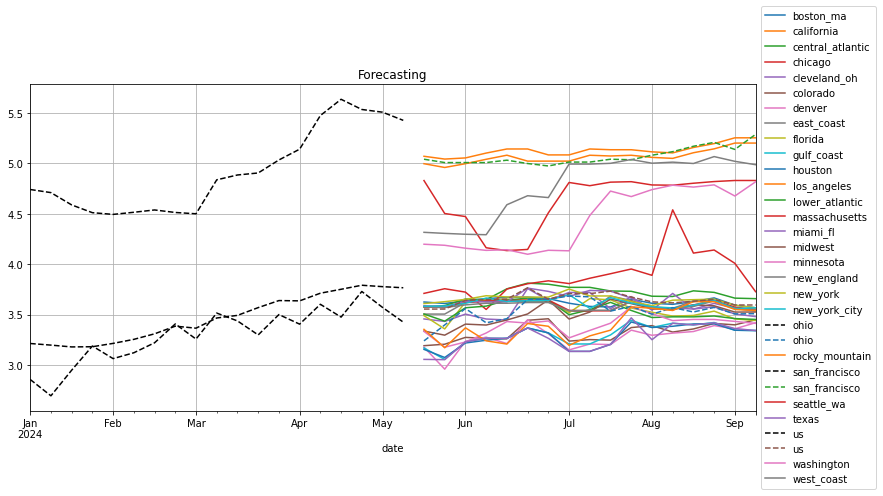

In [ ]:
plot_future_multiple_forecasting(
    df_history=dftp,
    df_forecasting=forecasting,
    target_col="price",
    date_col="date",
    forecasting_col="price",
    unique_id_col="region"
);


### 3.2. Stacking Forecasting


I will combine the forecasting with base XGB (not tuned, only with max_depth = 5 and 50 estimators) and base MSTL (season length of 52 and arima trend forecasting).

The main ideia is to join XGB and MSTL forecasts to get more accurated forecastings, but i need to individually check the forecasting in future, in real life, a expert will check this forecastings and provide to you a feedback about forecastings.

In [ ]:
forecasting = df3[f].copy()
dftp = df_test.copy()
dftp["region"] = dftp.region.map({v:k for k, v in region_mapping.items()})

xgb_feature_list = [
    'region', 'lag_4_months', 'lag_5_months', 'lag_12_months_plus',
    'lag_12_months', 'lag_12_months_minus', 'diff_4_months',
    'diff_5_months', 'diff_12_months_plus', 'diff_12_months',
    'diff_12_months_minus', 'latitude', 'longitude', 'day', 'year',
    'month', 'quarter', 'week', 'day_sin', 'day_cos', 'week_sin',
    'week_cos', 'month_sin', 'month_cos', 'quarter_sin', 'quarter_cos'
]

In [ ]:
xgb_loaded = mlflow.pyfunc.load_model("runs:/db896680cd374477ac915847b0bb0b8e/models/xgb_object")
mstl_loaded = mlflow.pyfunc.load_model("runs:/f468cab04a9e4371a71a9a68c9d459bf/models/sf_object")

df_mstl = mstl_loaded.predict(forecasting["date"].nunique()).reset_index()
df_mstl.rename(columns={"unique_id": "region", "ds": "date", "MSTL": "price"}, inplace=True)

xgb_yhat = xgb_loaded.predict(forecasting[xgb_feature_list])
forecasting["price"] = xgb_yhat

forecasting["region"] = forecasting["region"].map({v: k for k, v in region_mapping.items()})
forecasting = forecasting[["region", "date", "price"]]

# Sorting both to mean the series forecasts
forecasting = forecasting.sort_values(by=["date", "region"]).reset_index(drop=True)
df_mstl = df_mstl.sort_values(by=["date", "region"]).reset_index(drop=True)

forecasting["price"] = (df_mstl["price"] + forecasting["price"]) / 2

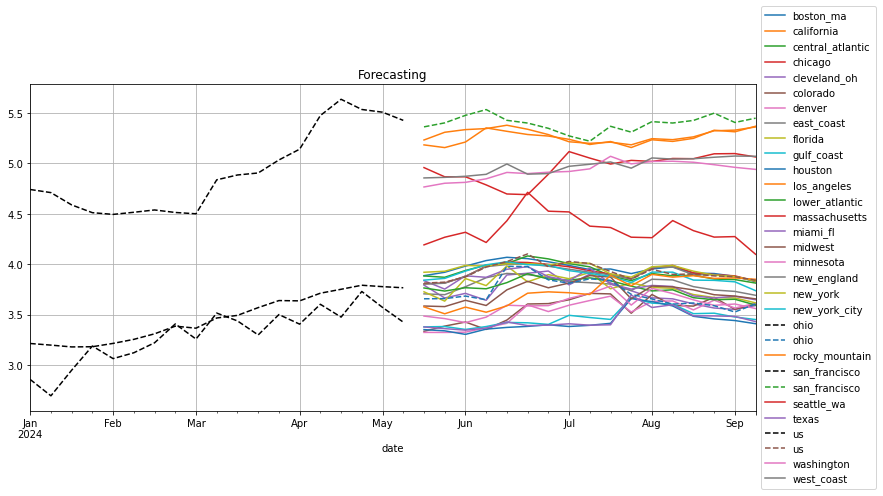

In [ ]:
plot_future_multiple_forecasting(
    df_history=dftp,
    df_forecasting=forecasting,
    target_col="price",
    date_col="date",
    forecasting_col="price",
    unique_id_col="region"
);